# Feature Variation

The purpose of this notebook is to see how the features (imports in this case) vary through time.

The first thing is to check in small dataset how the features vary and then do the same for all the imports. If in both cases the features vary in the same way, the LR made for the small dataset can behave similarly when used on the bigger dataset.

In [1]:
import lib.data_loading as jcfg_data_loading
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

dataset_name = "dataset"
numb_datasets = 6

datasets = []

# Load all samples with an array, where each ith position are samples
# up to the ith+1 submission of the target sample
for i in range(numb_datasets):
    datasets.append(pd.read_csv(dataset_name + str(i) + '.csv'))
    datasets[i] = datasets[i].set_index('md5')
    datasets[i].dropna(inplace=True, subset=['imports'])
    print('Final {0}th dataset size: {1}'.format(i, len(datasets[i])))

Final 0th dataset size: 2798
Final 1th dataset size: 31
Final 2th dataset size: 22
Final 3th dataset size: 121
Final 4th dataset size: 286
Final 5th dataset size: 465


In [2]:
# Parameters for the bag of words
# Split by the semicolon
count_vec_pattern = u'[^;]+'
# A call must be present at least in x samples
min_df = 2
max_df = 1.0

train_test = [datasets[0], pd.concat(datasets[1:])]

# Create the bag of words baseline
cv = CountVectorizer(token_pattern=count_vec_pattern, max_df=max_df, min_df=min_df)
cv.fit(train_test[0].imports)
cv2 = CountVectorizer(token_pattern=count_vec_pattern, max_df=max_df, min_df=min_df)
cv2.fit(train_test[1].imports)

train_features = list(cv.vocabulary_.keys())
test_features = list(cv2.vocabulary_.keys())
common_features = [i for i in train_features if i in test_features]

print('Number of train imports: {0}'.format(len(train_features)))
print('Number of test imports: {0}'.format(len(test_features)))
print('Common imports: {0} ({1:.3} of train)'.format(len(common_features), len(common_features)/len(train_features)))

Number of train imports: 10519
Number of test imports: 3976
Common imports: 3191 (0.303 of train)


In [3]:
all_imports = pd.read_csv('data/imports.csv')
all_imports['date'] = pd.to_datetime(all_imports['date'], format='%Y/%m/%d')
# Set date as index
all_imports = all_imports.set_index('date')
# Drop useless columns
all_imports.drop(labels=['md5', 'link', 'malware'], axis=1, inplace=True)
all_imports.dropna(inplace=True)

In [4]:
cv_list = []

# Split the imports into groups of 3k
for _, df in all_imports.groupby(np.arange(len(all_imports)) // 3000):
    # Create the bag of words for each one
    cv = CountVectorizer(token_pattern=count_vec_pattern, max_df=max_df, min_df=min_df)
    cv.fit(df.imports)
    cv_list.append(cv)

,common,new
count,22.000000,22.000000
mean,0.594614,0.388238
std,0.178714,0.164312
min,0.287310,0.115340
25%,0.460002,0.252902
50%,0.625383,0.366247
75%,0.744234,0.527197
max,0.843224,0.669629


,common,new
0,0.663638,0.335054
1,0.486908,0.562379
2,0.357149,0.292328
3,0.528832,0.189549
4,0.789703,0.283856
5,0.837631,0.296116
6,0.746242,0.225015
7,0.801135,0.590975
8,0.438419,0.397440
9,0.631863,0.603464


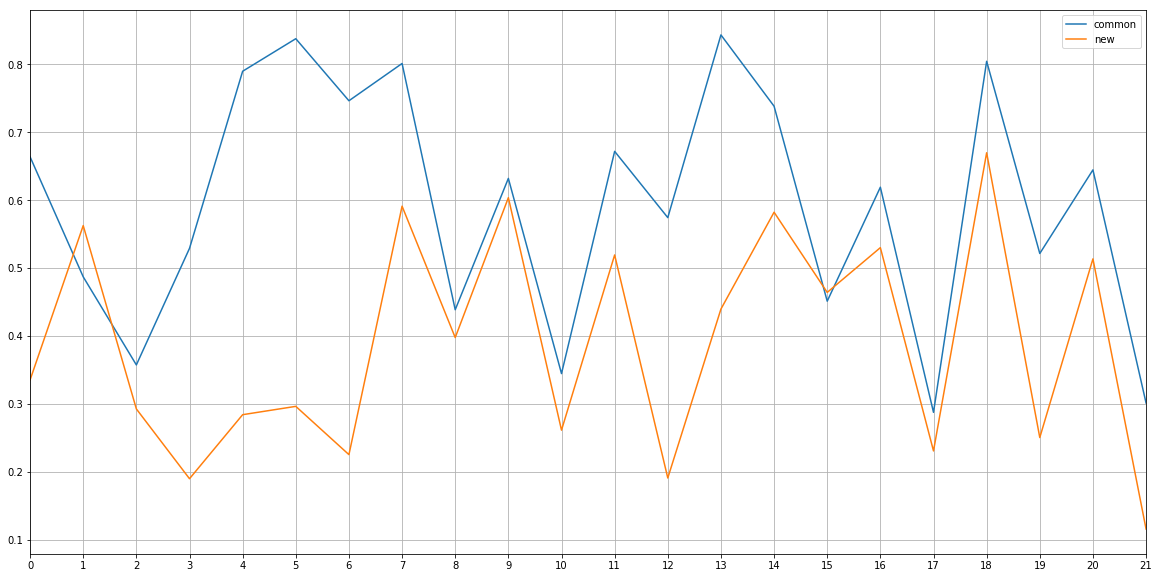

In [8]:
# Create a dataframe with relevant information
features = pd.DataFrame(data=[len(cv.vocabulary_.keys()) for cv in cv_list])
features.columns = ['count']


comparison = pd.DataFrame(index=np.arange(len(cv_list) - 1))
common = []
new = []
# removed = []

for i in zip(cv_list[::1], cv_list[1::1]):
    cv_old = i[0].vocabulary_.keys()
    cv_new = i[1].vocabulary_.keys()
    # Get percentage of common features, percentage is based on the old features
    common.append(len([i for i in cv_old if i in cv_new]) / len(cv_old))
    # Get percentage of new features, percentage is based on the new features
    new.append(len([i for i in cv_new if i not in cv_old]) / len(cv_new))
    # Get percentage of removed features, percentage is based on the old features,
    # values are the symmetric of the common, uncomment just for visualization
    # removed.append(len([i for i in cv_old if i not in cv_new]) / len(cv_old))
    

comparison = comparison.assign(common=common)
comparison = comparison.assign(new=new)
# comparison = comparison.assign(removed=removed)

display(comparison.describe())
display(comparison)
# display(features)
ax = comparison.plot(figsize=(20, 10), xticks=np.arange(0, len(comparison)), grid=True)
# plt.ylabel('# Features')
# plt.xlabel('Bags')
plt.show()